In [23]:
# TEST GPU
import torch


print('Cuda availability :',torch.cuda.is_available())
print('How many cuda device :', torch.cuda.device_count())
cuda_device = torch.cuda.current_device()
print('Name of current device :',torch.cuda.get_device_name(cuda_device))

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

Cuda availability : True
How many cuda device : 1
Name of current device : NVIDIA GeForce RTX 3090


In [2]:
# pass data to device
def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [3]:
class DeviceDataLoader:
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield  to_device(b, self.device)

    def __len__(self):
        """number of batches"""
        return len(self.dl)

In [4]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [5]:
dataset = MNIST(root='data/',
                download=True,
                transform=ToTensor())

/home/divclab/anaconda3/envs/torch-env/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448272031/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
def split_indices(n, val_percent):

    # size of validation set
    n_val = int(val_percent * n)
    # random permutation of 0 to n-1
    idxs = np.random.permutation(n)

    return idxs[n_val:], idxs[:n_val]

In [7]:
train_indices, val_indices = split_indices(len(dataset), val_percent=0.2)

print(len(train_indices), len(val_indices))


48000 12000


In [8]:
batch_size = 100

train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler=train_sampler)
train_dl = DeviceDataLoader(train_dl, device)

valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                      batch_size,
                      sampler=valid_sampler)
valid_dl = DeviceDataLoader(valid_dl, device)

In [9]:
for xb, yb in valid_dl:
    print('xb.device:', xb.device)
    print('yb:', yb)

    break

xb.device: cpu
yb: tensor([0, 7, 2, 0, 6, 5, 4, 2, 0, 7, 2, 2, 3, 6, 6, 8, 3, 4, 2, 7, 6, 3, 9, 3,
        7, 9, 3, 9, 5, 7, 8, 5, 8, 7, 8, 4, 6, 9, 5, 3, 3, 5, 5, 7, 9, 6, 1, 9,
        3, 9, 3, 1, 6, 8, 6, 4, 9, 3, 2, 1, 0, 9, 8, 2, 6, 3, 9, 8, 9, 6, 7, 4,
        1, 8, 3, 1, 6, 1, 7, 2, 7, 7, 9, 5, 2, 9, 9, 8, 2, 2, 6, 8, 7, 7, 2, 7,
        1, 7, 3, 1])


In [10]:
import torch.nn.functional as F
import torch.nn as nn

In [11]:
for xb, yb in train_dl:
    print(xb.shape)
    xb = xb.view(xb.size(0),784)
    print(xb.shape)
    break

torch.Size([100, 1, 28, 28])
torch.Size([100, 784])


In [12]:
class MnistModel(nn.Module):
    """feedforward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()

        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)

        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):

        # flatten (-1 means auto calculate)
        xb = xb.view(xb.size(0), -1)

        out = self.linear1(xb)
        out = F.relu(out)

        out = self.linear2(out)

        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)#create predictions
        loss = F.cross_entropy(out, labels) # loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)

        return {'val_loss':loss, 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        epoch_acc = torch.stack(batch_accs).mean()

        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    def epoch_end(selfself, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}"
                .format(epoch, result['val_loss'], result['val_acc']))

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/ len(preds))

In [21]:
input_size = 28*28
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size=num_classes)
to_device(model, device)

# chekcout parameter shapes
for t in model.parameters():
    print(t.shape)


torch.Size([3200, 784])
torch.Size([3200])
torch.Size([10, 3200])
torch.Size([10])


In [15]:
for images, labels in train_dl:
    print('images.shape', images.shape, images.device)

    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape:', outputs.shape)
print('sample outputs:\n', outputs[0].data)
print('after softmax:\n', F.softmax(outputs, dim=0)[0].data)

images.shape torch.Size([100, 1, 28, 28]) cpu
Loss: 2.3037989139556885
outputs.shape: torch.Size([100, 10])
sample outputs:
 tensor([-0.0626,  0.1212,  0.0689,  0.2596,  0.1062, -0.1024, -0.0115,  0.1106,
        -0.0465, -0.0732])
after softmax:
 tensor([0.0097, 0.0114, 0.0103, 0.0103, 0.0103, 0.0102, 0.0104, 0.0109, 0.0091,
        0.0115])


In [16]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [17]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.296910285949707, 'val_acc': 0.11183332651853561}]

In [22]:
history += fit(epochs=5, lr=0.5, model=model, train_loader=train_dl, val_loader=valid_dl)

Epoch [0], val_loss: 0.1448, val_acc: 0.9567
Epoch [1], val_loss: 0.1036, val_acc: 0.9684
Epoch [2], val_loss: 0.0905, val_acc: 0.9714
Epoch [3], val_loss: 0.0840, val_acc: 0.9748
Epoch [4], val_loss: 0.0731, val_acc: 0.9790


Text(0.5, 1.0, 'loss vs No. of epoch')

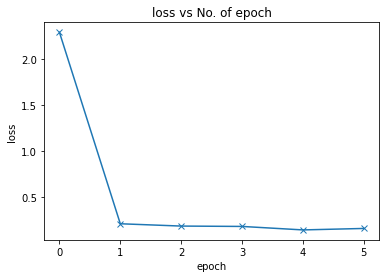

In [19]:
import matplotlib.pyplot as plt
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss vs No. of epoch')

Text(0.5, 1.0, 'acc vs No. of epoch')

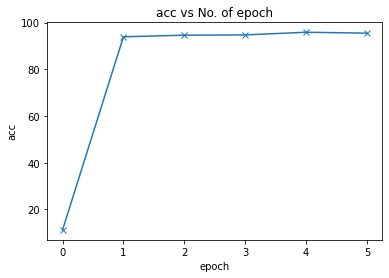

In [20]:
accs = [x['val_acc']*100 for x in history]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('acc vs No. of epoch')
